# Setup

First, do all our imports

In [1]:
from datetime import datetime
import json
from pathlib import Path
import textwrap
from urllib.request import urlretrieve

import matplotlib.patheffects as pe
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plot_styles
import seaborn as sns
import spotipy

today = datetime.now().strftime('%Y-%m-%d')
today

'2022-01-01'

In [2]:
graphs_dir = Path('')

Apply `matplotlib` settings.

In [3]:
plt.style.use('blog')
plt.rcParams['font.sans-serif'] = ['Pour And Destroy'] + plt.rcParams['font.sans-serif']

We're going to reuse some colours and styles, so let's define them here. In particular, we're going to apply edge and shadow styling and want to vary it sightly for different text.

In [4]:
EDGE_COLOUR = plt.rcParams['axes.edgecolor']
BACKGROUND_COLOUR = plt.rcParams['figure.facecolor']

SHADOW = pe.SimplePatchShadow(offset=(3, -3), shadow_rgbFace='C0')
SMALL_SHADOW = pe.SimplePatchShadow(offset=(1.5, -1.5), shadow_rgbFace='C0')

STROKE = pe.Stroke(linewidth=2, foreground=BACKGROUND_COLOUR)
SMALL_STROKE = pe.Stroke(linewidth=1, foreground=BACKGROUND_COLOUR)

We'll cache our downloaded data, to reduce the number of calls to the Spotify API.

In [5]:
data_cache = Path('Data Cache')
data_cache.mkdir(exist_ok=True)

graph_dir = Path('Graphs')
graph_dir.mkdir(exist_ok=True)

Now, our list of albums to search for. This dictionary has:
- rank within the list as key
- a tuple of (album, artist) to search Spotify for as the key.

In [6]:
albums = {
    1: ('Ultrapop', 'The Armed'),
    2: ('The Cold In Every Shelter', 'I Feel Fine'),
    3: ('Dream Weapon', 'Genghis Tron'),
    4: ('Illusory Walls', 'The World Is A Beautiful Place'),
    5: ('Pono', 'A Great Big Pile of Leaves'),
    6: ('Gami Gang', 'Origami Angel'),
    7: ('Collapsed in Sunbeams', 'Arlo Parks'),
    8: ('Future Suits', 'Pet Symmetry'),
    9: ('Glow On', 'Turnstile'),
    10: ('The Million Masks of God', 'Manchester Orchestra')
}

First, set up our authorised connection.

In [7]:
auth = spotipy.SpotifyOAuth(
    redirect_uri='http://localhost:8889/callback', username='valeadam'
)
sp = spotipy.Spotify(auth_manager=auth)

Now we can get our data. If we've already obtained it, we can just pull from the cache. If not, we search to get the album and then get all the other info we need.

In [8]:
frames = []

for rank, (album, artist) in albums.items():
    file_path = data_cache / f'{album}_{artist}.json'
    
    # Get / load the main info for the album
    if file_path.is_file():
        alb_obj = json.load(file_path.open())
    else:
        search_results = sp.search(f'{album} artist:{artist}', type='album', market='GB')
        
        alb_obj = sp.album(search_results['albums']['items'][0]['id'])
        json.dump(alb_obj, file_path.open('w'))
    
    # Simplified names for plotting etc
    album_name = alb_obj['name']
    artists = ', '.join(artist['name'] for artist in alb_obj['artists'])
    
    # Save album art! Use Spotify's album name and artists for simplicity later on
    image_path = data_cache / f'{album_name}_{artists}.jpg'
    if not image_path.is_file():
        urlretrieve(alb_obj['images'][0]['url'], image_path)
    
    # We need to pull out the tracks in order to get the audio features
    tracks = alb_obj['tracks']['items']
    
    # Get audio features
    feat_file = file_path.with_name(file_path.stem + '_features' + file_path.suffix)
    if feat_file.is_file():
        audio_features = json.load(feat_file.open())
    else:
        audio_features = sp.audio_features([t['id'] for t in tracks])
        json.dump(audio_features, feat_file.open('w'))
    
    merged = pd.DataFrame(tracks)\
               .merge(pd.DataFrame(audio_features), on='id')\
               .assign(Rank=rank, Album=album_name, Artists=artists)
    
    frames.append(merged)

data = pd.concat(frames, ignore_index=True)

What measures are we going to plot alongside the art. Thse threeseem the most sensible to me.

In [9]:
MEASURES = ['danceability', 'energy', 'valence']

Now we actually plot! A lot of this is kinda fragile code-wise, particularly in terms of ratios and spacing, but it does the trick for a top 10.

In [10]:
ANNOTATION_TEXT = f'''Data obtained from Spotify on {today}
Valence refers to "the musical positiveness conveyed by a track"
For more information, visit ruszkow.ski/posts/2022-01-01-album-of-the-year-2021'''

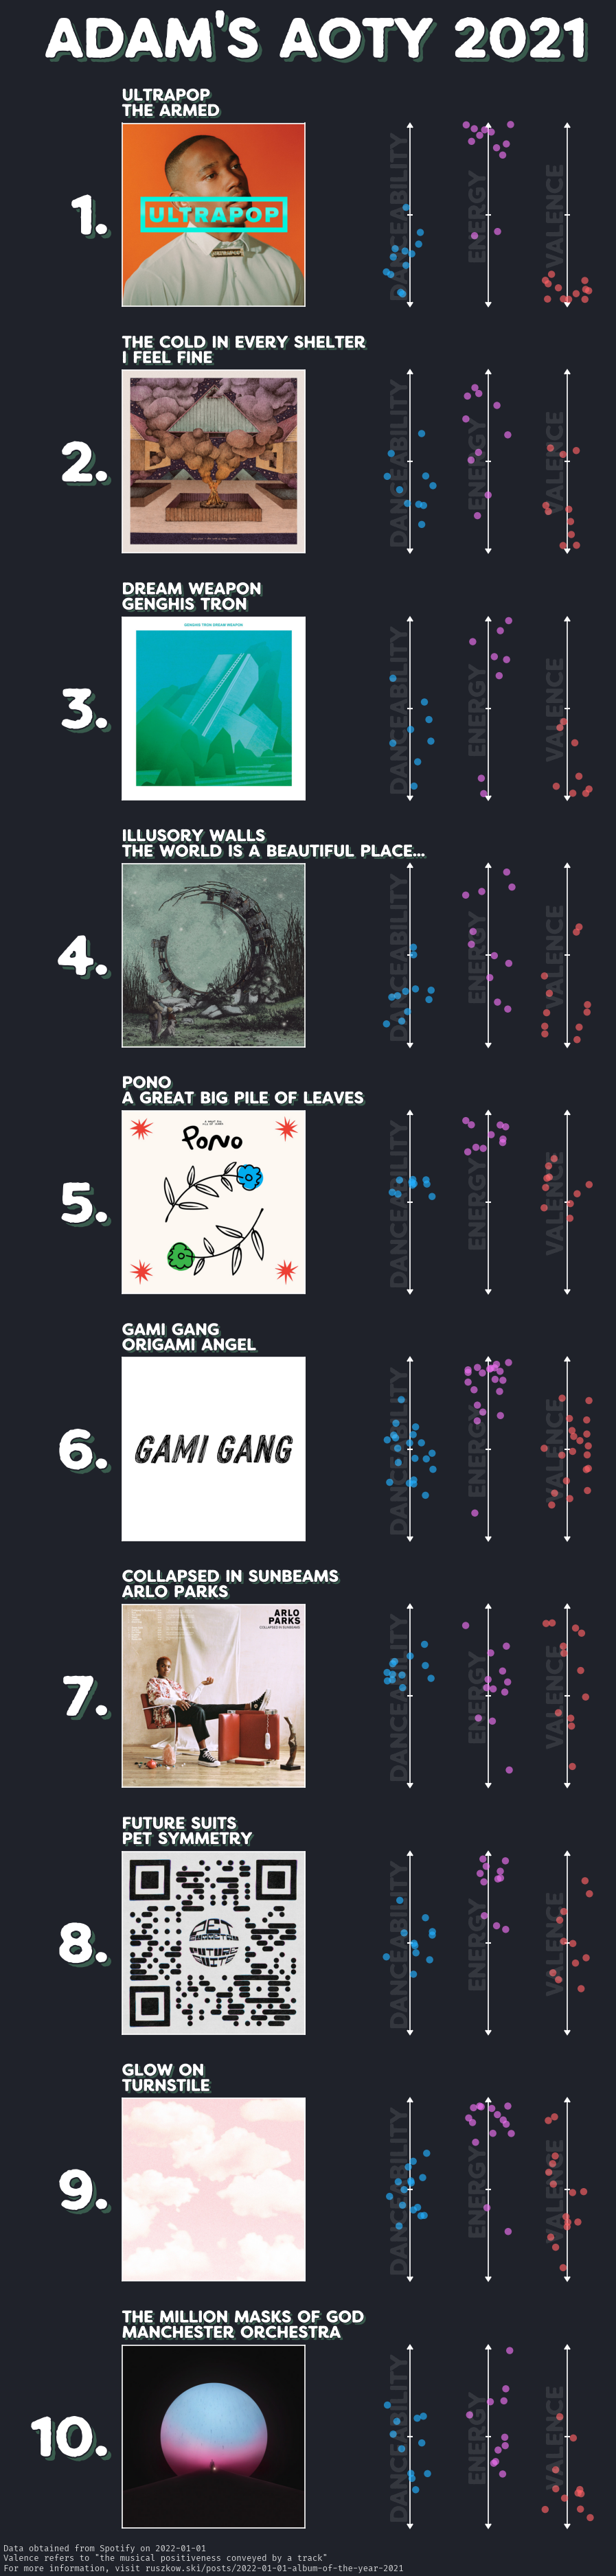

In [11]:
np.random.seed(1)

widths = [4] + [1]*len(MEASURES)
heights = [2] * len(albums.keys())

fig = plt.figure(constrained_layout=False, figsize=(6, 2.5*len(heights)))

# Set up our title with the nice text effects
title = fig.suptitle('Adam\'s AOTY 2021', size=40, y=0.975, va='bottom')
title.set_path_effects([SHADOW, STROKE, pe.Normal()])

# Set up our grid.
spec = fig.add_gridspec(
    ncols=len(widths), nrows=len(heights), 
    width_ratios=widths, height_ratios=heights, 
    wspace=0, hspace=0.35, 
    left=0.08, right=0.97, top=0.95, bottom=0.016
)

# Loop over the albums
for rank, album_data in data.groupby('Rank'):
    album_name = album_data.iloc[0]['Album']
    artists = album_data.iloc[0]['Artists']
    art_path = data_cache / f'{album_name}_{artists}.jpg'
    
    # Wrap long artists
    if len(artists) > 30:
        artists = f'{textwrap.wrap(artists, 30)[0]}...'
    
    # Now for each plot
    for col in range(len(widths)):
        ax = fig.add_subplot(spec[rank-1, col])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
        # Show spines for album art, but none of the measure charts
        for side in ['left', 'right', 'top', 'bottom']:
            ax.spines[side].set_visible(col==0)
        
        # Column 0 is where we show our album art
        if col == 0:
            # Show the ranking number
            rank_text = ax.annotate(
                f'{rank}.', xy=(0, 0.5), xycoords='axes fraction', ha='right', va='center', 
                xytext=(-20, 0), textcoords='offset pixels', size=40
            )
            rank_text.set_path_effects([SHADOW, STROKE, pe.Normal()])
            
            # Show the album art
            ax.imshow(mpimg.imread(art_path), aspect='equal', cmap='gray')
            
            label = ax.annotate(f'{album_name}\n{artists}', xy=(0, 1), xycoords='axes fraction', ha='left', va='bottom', xytext=(0, 10), textcoords='offset pixels', size=12)
            label.set_path_effects([SMALL_SHADOW, SMALL_STROKE, pe.Normal()])
        else:
            current_measure = MEASURES[col-1]
            
            # Values are on a scale of 0-1
            ax.set_ylim(0, 1)
            
            # Add in our vertical scale line - the points will be plotted either side of it
            ax.axvline(x=0, lw=plt.rcParams['axes.linewidth'], c=EDGE_COLOUR, zorder=1)
            
            # Add in arrows and midpoint to vline
            ax.plot(0, 1, ls='', marker=6, ms=4, color=EDGE_COLOUR, clip_on=False, zorder=1)
            ax.plot(0, 0, ls='', marker=7, ms=4, color=EDGE_COLOUR, clip_on=False, zorder=1)
            ax.plot(0, 0.5, ls='', marker='_', ms=4, color=EDGE_COLOUR, clip_on=False, zorder=1)
            
            # Large text label for the current measure!
            measure = ax.annotate(
                current_measure, xy=(0, 0.5), xytext=(-5, 0), textcoords='offset pixels', 
                ha='right', va='center', rotation=90, alpha=0.1, size=17
            )
            
            sns.stripplot(y=album_data[current_measure], clip_on=False, alpha=0.65, jitter=0.3, marker='o', zorder=2, color=f'C{col}')

# Add our annotation at the bottom of the image!
ax.annotate(
    ANNOTATION_TEXT, 
    xy=(0, 0), xycoords='figure fraction', va='bottom', size='xx-small', xytext=(5, 5), textcoords='offset pixels',
    alpha=0.8, fontname='Fira Code'
)

plt.savefig(graph_dir / 'Adam AOTY Ranking.png')